In [2]:
#Group_21_stage_2.ipynb
#John MacDonald - 84396878
#Aiden Skinner - 60479607
#test


In [3]:
import os # to listdir
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from PIL import Image # python image lib
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image, ImageFilter
import cv2
import random

#name training and testing folders
folder_training = 'Lego_dataset_2/training/'  
folder_testing = 'Lego_dataset_2/testing/' 


classes = [0, 1, 2, 3] #define number of classes
name_dict={0:"2x1",1:"cir",2:"rec",3:"squ"} #dictonary containg prefix of each class
count_training=np.zeros(len(classes))#initialize training data points counter 
count_testing=np.zeros(len(classes))#initialize testing data points counter 
file_counts_training = {}
file_counts_testing ={}

#Number of training data points belonging to each class is counted individually
for file in os.listdir(folder_training):
    file_type = file.split("_")[0] #isolates file prefix  
    
    if file_type in file_counts_training: 
        file_counts_training[file_type]+=1 #increases file cout by 1 if file type in dictionary
    else:
        file_counts_training[file_type] = 1 #sets file count to 1 if file type not in dictonary
    
for i in range(len(classes)):
    count_training[i]=file_counts_training[name_dict[i]] #counts number of files for each class
    print('training data points of',name_dict[i],'is:',count_training[i])
    
    
#Number of testing data points belonging to each class is counted individually
for file in os.listdir(folder_testing):
    file_type = file.split("_")[0]#isolates file prefix  
    
    if file_type in file_counts_testing:
        file_counts_testing[file_type]+=1 #increases file cout by 1 if file type in dictionary
    else:
        file_counts_testing[file_type] = 1 #sets file count to 1 if file type not in dictonary
    
for i in range(len(classes)):
    count_testing[i]=file_counts_testing[name_dict[i]] #counts number of files for each class
    print('testing data points of',name_dict[i],'is:',count_testing[i])



training data points of 2x1 is: 27.0
training data points of cir is: 27.0
training data points of rec is: 27.0
training data points of squ is: 27.0
testing data points of 2x1 is: 27.0
testing data points of cir is: 27.0
testing data points of rec is: 27.0
testing data points of squ is: 27.0


In [4]:
#Function retrieves the respective files from the respective folder and converts the given image into a greyscale array. Returns the created array and the labels for a given class. 
def get_data(folder,im_width,label,n_samples):
    file_names = os.listdir(folder)
    x = np.empty((n_samples,im_width**2))
    y = np.empty((n_samples,1))
    for i in range(n_samples):#iterate for number of samples in the respective class
        path = folder + file_names[classes[label]*n_samples+i]#retrieves path for a file of the given class 
        #print(path)
        #print(i)
        #print(n_samples)
        im = Image.open(path).convert('L')
        im = im.resize((im_width,im_width))
        im_array = asarray(im)
        x[i,:] = im_array.reshape(1,-1)
        y[i,0] = classes[label]
    return x, y




In [5]:
#Collects all the training, and testing, data into respective arrays as greyscale values and labels

im_width = 200 #square image pixel size 

def image_extract(im_width,count_testing=count_testing,count_training=count_training):
    P_training_total=int(sum(count_training))#Returns total number of training files
    P_testing_total=int(sum(count_testing))#Returns total number of testing files 

    x_train = np.empty((P_training_total,im_width**2))#training size by image pixel
    y_train = np.empty((P_training_total,1))#training size by class

    #Training data of photo pixels is collected into x_train while there respective labels are colled into y_train
    for i in range(0,len(classes)):
        x_i, y_i = get_data(folder_training,im_width,i,int(count_training[i])) #iterates for each class in training folder
        x_train[int(sum(count_training[0:i])):int(sum(count_training[0:i+1])),:] = x_i #splices x training folder into classes 
        y_train[int(sum(count_training[0:i])):int(sum(count_training[0:i+1])),:] = y_i #splices y training folder into classes

    print(x_train.shape,y_train.shape)

    #Testing data of photo pixels is collected into x_test while there respective labels are colled into y_test
    x_test = np.empty((P_testing_total,im_width**2))#training size by image pixel
    y_test = np.empty((P_testing_total,1))#training size by class

    for i in range(0,len(classes)):
        x_i, y_i = get_data(folder_testing,im_width,i,int(count_testing[i])) #iterates for each class in training folder
        x_test[int(sum(count_testing[0:i])):int(sum(count_testing[0:i+1])),:] = x_i #splices x training folder into classes 
        y_test[int(sum(count_testing[0:i])):int(sum(count_testing[0:i+1])),:] = y_i #splices y training folder into classes


    
    return x_train,y_train,x_test,y_test


In [6]:
x_train,y_train,x_test,y_test=image_extract(im_width)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(108, 40000) (108, 1)
(108, 40000) (108, 1) (108, 40000) (108, 1)


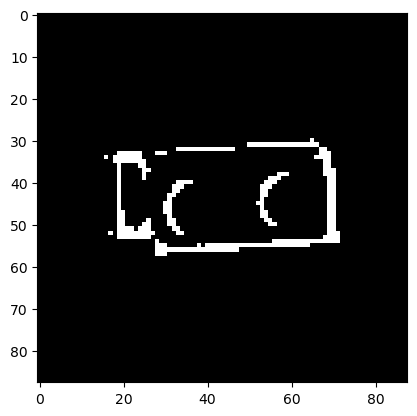

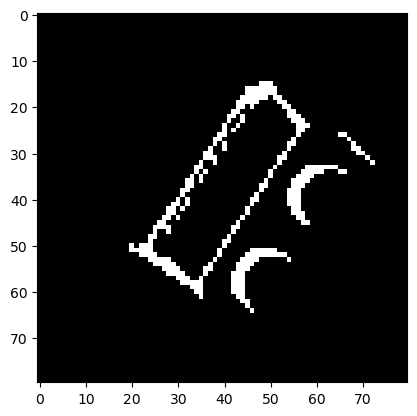

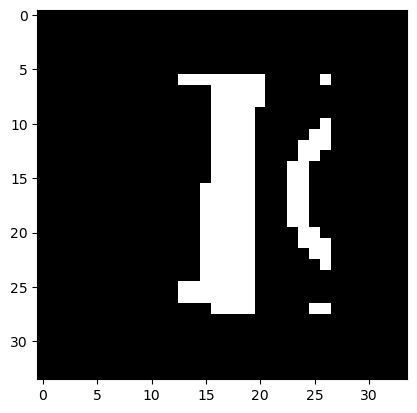

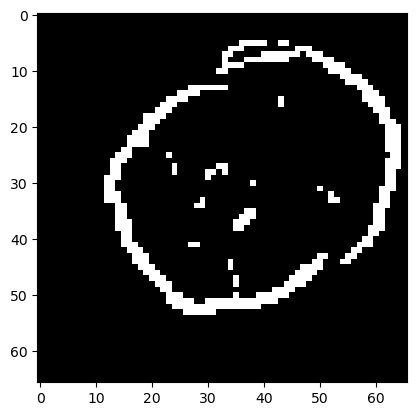

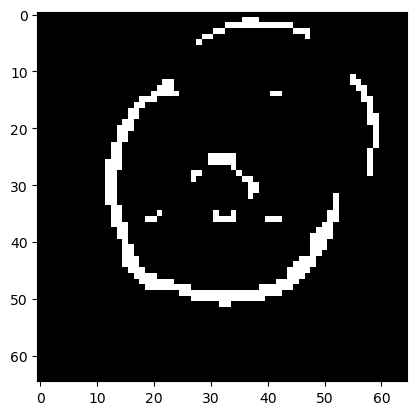

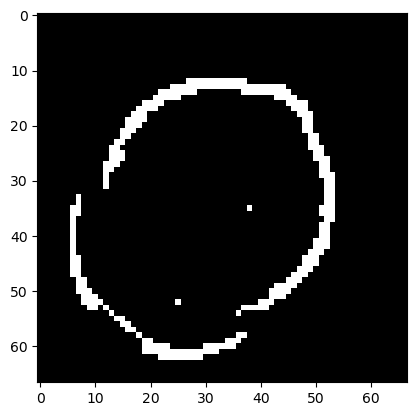

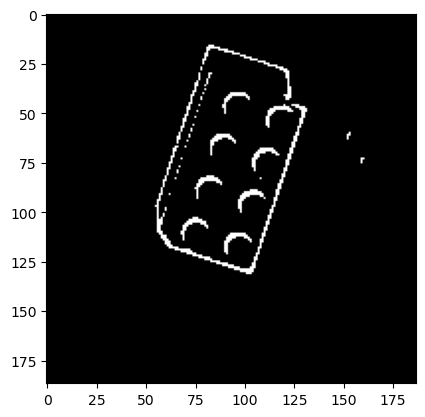

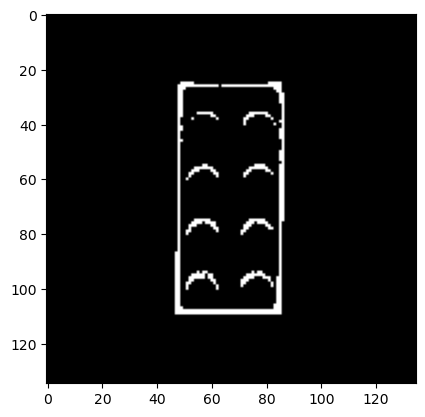

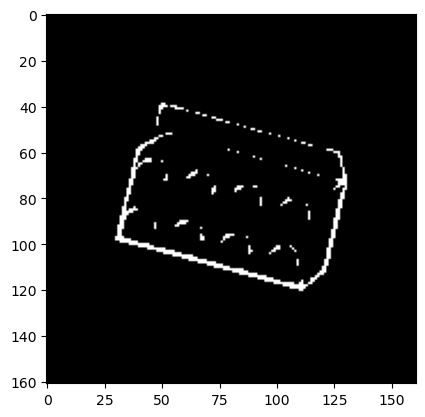

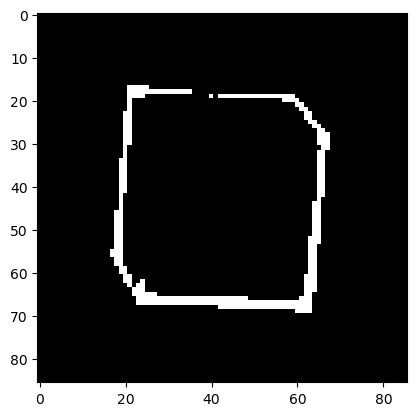

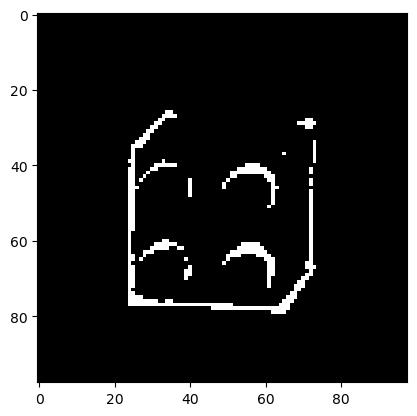

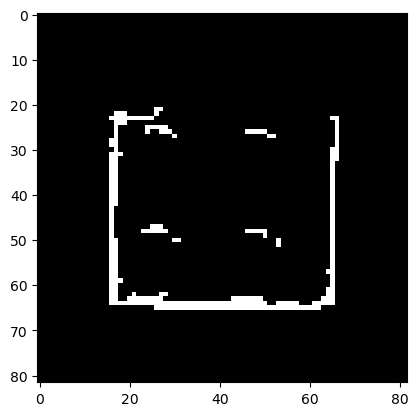

In [7]:
def crop_and_center_lego(image_vector,block_size,constant_sub):

    # Convert the image from a row vector to a 2D array
    image = np.array(image_vector).reshape((int(np.sqrt(len(image_vector))), -1))
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    
    
    # Apply a threshold to separate the Lego block from the background
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, constant_sub)
    
    # Find contours in the threshold image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) > 0:
        # Find the largest contour which will be the Lego block
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Add 30% more margins to the bounding box
        margin = int(max(w, h) * 0.3)
        x = max(0, x - margin)
        y = max(0, y - margin)
        w = min(image.shape[1] - x, w + 2 * margin)
        h = min(image.shape[0] - y, h + 2 * margin)
        
        # Crop the image to the bounding box
        cropped = image[y:y+h, x:x+w]
        
        # Resize the cropped image to a square
        max_dim = max(cropped.shape[0], cropped.shape[1])
        square_image = np.ones((max_dim, max_dim), dtype=np.uint8) * np.mean([image[0, 0], image[0, -1], image[-1, 0], image[-1, -1]])
        x_offset = (max_dim - cropped.shape[1]) // 2
        y_offset = (max_dim - cropped.shape[0]) // 2
        square_image[y_offset:y_offset+cropped.shape[0], x_offset:x_offset+cropped.shape[1]] = cropped
        
        # Convert the square image to the appropriate type
        square_image = cv2.normalize(square_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        
        # Apply the threshold to the cropped image
        cropped_thresh = cv2.adaptiveThreshold(square_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 20)
        
        # Convert the cropped image back to a row vector
        result_vector = cropped_thresh.flatten()
        
        return result_vector, square_image.shape[0], cropped.shape[1], cropped.shape[0], cropped
    else:
        return None, None, None, None

   


num_samples = 27
num_classes = len(classes)
num_samples_per_class = 3

for class_label in range(num_classes):
    class_samples = random.sample(range(class_label * num_samples, (class_label + 1) * num_samples), num_samples_per_class)
    
    for sample_index in class_samples:
        image_array = x_train[sample_index, :]
        result = crop_and_center_lego(image_array,7,5)
        #print(result[11])    
        plt.imshow(result[0].reshape((result[1], result[1])), cmap='gray')
        plt.show()




In [8]:
def PNR(image_array,im_width,params_M,peak_thresh):
    # scale colours to be between 0 and 255
    image_array=(image_array-np.min(image_array))*255/(np.max(image_array)-np.min(image_array))
    # convert array (1 row) to grey scale
    edges_array_scaled = Image.fromarray(image_array.reshape(im_width,im_width)).convert('L')
    
        
    # engineer features 
    edges_v=np.sum(edges_array_scaled,axis=0).astype(float) # vertical edges 
    edges_h=np.sum(edges_array_scaled,axis=1).astype(float) # horizontal edges
        
    #plt.plot(edges_v)
    #plt.plot(edges_h)
    #plt.show()
            
    # highpass filter
    M=params_M
    for i in range(len(edges_v)-M):
        edges_v[i]=edges_v[i]-np.mean(edges_v[i:i+M])
    edges_v[-M:]=0
    for i in range(len(edges_h)-M):
        edges_h[i]=edges_h[i]-np.mean(edges_h[i:i+M])   
    edges_h[-M:]=0
            
    #plt.plot(edges_v)
    #plt.plot(edges_h)
    #plt.show()

    # find peak to noise ratio
    peak_v = np.max(np.abs(edges_v))
    peak_h = np.max(np.abs(edges_h))
    noise_v = edges_v.copy()[np.abs(edges_v)<peak_thresh*peak_v]
    noise_h = edges_h.copy()[np.abs(edges_h)<peak_thresh*peak_h]
    sd_v=np.sqrt(np.var(noise_v))
    sd_h=np.sqrt(np.var(noise_h))
    
    if sd_v == 0:
        PNR_V = 0
    else:
        PNR_V = peak_v/sd_v
    
    if sd_h == 0:
        PNR_H = 0
    else:
        PNR_H = peak_h/sd_h
    
    x=np.array([PNR_V, PNR_H]).reshape(1,-1)

    return PNR_V,PNR_H,peak_v,peak_h



            

In [9]:
import numpy as np
from scipy.ndimage import rotate



def rotate_image(row_vector, im_width,paramsM,peak_thresh):
    # Reshape the row vector back into a rectangular matrix
    image = row_vector.reshape((im_width, im_width))

    new_angle=0
    max_PNR_v=0
    max_PNR_h=0
    max_combinedPNR=0
    peak_v_real=0
    peak_h_real=0

    for angle in range (91):

        # Calculate the average border color from the unrotated image
        border_color = np.mean([image[0, :], image[-1, :], image[:, 0], image[:, -1]])

        # Rotate the image
        rotated_image = rotate(image, angle, reshape=False, cval=border_color)

        # Remove the overextending portion of the image
        rotated_image = rotated_image[:im_width, :im_width]

        # Flatten the image back into a row vector
        rotated_row_vector = rotated_image.flatten()

        PNR_v,PNR_h,peak_v,peak_h = PNR(rotated_row_vector,im_width,paramsM,peak_thresh)

        combinedPNR=PNR_v+PNR_h

        if max_combinedPNR<combinedPNR:
            max_combinedPNR=combinedPNR
            new_angle=angle
            max_PNR_v=PNR_v
            max_PNR_h=PNR_h
            peak_v_real=peak_v
            peak_h_real=peak_h
    
    # Calculate the average border color from the unrotated image
    border_color = np.mean([image[0, :], image[-1, :], image[:, 0], image[:, -1]])
    # Rotate the image
    rotated_image = rotate(image, new_angle, reshape=False, cval=border_color)
    # Remove the overextending portion of the image
    rotated_image = rotated_image[:im_width, :im_width]
    # Flatten the image back into a row vector
    rotated_row_vector = rotated_image.flatten()
        

    return rotated_row_vector,max_PNR_v,max_PNR_h,peak_v_real,peak_h_real,new_angle




# image2=crop_and_center_lego(x_train[4,:])
# image3=rotate_image(image2[0], image2[1])
# plt.imshow(image3.reshape((image2[1], image2[1])), cmap='gray')


In [10]:
import cv2
import numpy as np

def detect_circles(image_vector, im_length, im_width):
    # Reshape the image_vector into a 2D array
    image = np.reshape(image_vector, (im_width, im_length))

    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Ensure the grayscale image has the correct data type
    gray = gray.astype(np.uint8)

    # plt.imshow(gray, cmap='gray')
    # plt.show()  

    # Define the ROI as a 15x15 box at the center of the image
    w, h = 30, 30
    x, y = (im_width - w) // 2, (im_length - h) // 2
    roi = gray[y:y+h, x:x+w]

    # Calculate the mean value of the ROI
    mean_val = cv2.mean(roi)[0]
    #print(mean_val)

    # Calculate the maximum and minimum pixel values in the border of the image
  

    

    # Adjust the contrast of the image based on the mean value of the ROI
    if mean_val > 70:
        contrast_img = cv2.convertScaleAbs(gray, alpha=.8, beta=-30)
    else:
        contrast_img = cv2.convertScaleAbs(gray, alpha=1.2, beta=0)

    # Apply histogram equalization to the contrast-adjusted image
    #equalized = cv2.equalizeHist(contrast_img)

    # Apply Gaussian blur to the equalized image
    blurred = cv2.GaussianBlur(contrast_img, (3, 3), 0)

    #Threshold the image
   
    

    # plt.imshow(contrast_img, cmap='gray')    
    # plt.show()

    # Perform the Hough Circle Transform to detect circles
    circles = cv2.HoughCircles(contrast_img, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=100, param2=10, minRadius=5, maxRadius=10)

 

    circlesBig = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=200, param1=80, param2=20, minRadius=20, maxRadius=100)

    # If circles were found...
    if circles is not None:
        # Convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        number_of_circles = len(circles)
        # Return the number of circles
    else:
        number_of_circles = 0
    if circlesBig is not None:
            circlesBig = np.round(circlesBig[0, :]).astype("int")
            number_of_circlesBig = len(circlesBig)  
    else:
        circlesBig = 0
        number_of_circlesBig = 0
        
    return number_of_circles, number_of_circlesBig

In [11]:
def symmetry_test(image_array, im_width, paramsM, peak_thresh):
    # Reshape the image_array into a 2D array
    image = image_array.reshape((im_width, im_width))

    PNR_v = np.zeros(5)
    PNR_h = np.zeros(5)
    peak_v = np.zeros(5)
    peak_h = np.zeros(5)
    #print(PNR_v.shape)

    # Perform symmetry test for each angle
    for i in range(3):
        angle = i * 45

        # Calculate the average border color from the unrotated image
        border_color = np.mean([image[0, :], image[-1, :], image[:, 0], image[:, -1]])

        # Rotate the image
        rotated_image = rotate(image, angle, reshape=False, cval=border_color)

        # Remove the overextending portion of the image
        rotated_image = rotated_image[:im_width, :im_width]

        # Flatten the image back into a row vector
        rotated_row_vector = rotated_image.flatten()

        PNR_v[i], PNR_h[i], peak_v[i], peak_h[i] = PNR(rotated_row_vector, im_width, paramsM, peak_thresh)

    symmetry_PNR_v = np.var([PNR_v[0], PNR_v[1]])
    symmetry_PNR_h = np.var([PNR_h[0], PNR_h[1]]) 
    symmetry_peak_v = np.var(peak_v)
    symmetry_peak_h = np.var(peak_h)
    symmetry_PNR_1d_v = np.var([PNR_v[0], PNR_v[2]])
    symmetry_PNR_1d_h = np.var([PNR_h[0], PNR_h[2]])
 

    return symmetry_PNR_v, symmetry_PNR_h, symmetry_peak_v, symmetry_peak_h,symmetry_PNR_1d_v,symmetry_PNR_1d_h

ac=symmetry_test(x_train[30,:],200,10,0.5)
print(ac)


    

(0.00045343925081806074, 0.007723084202859435, 3727316.374399998, 3385671.0304000005, 0.060046192694502315, 0.030010092856667003)


In [12]:
import random
def image_process(image_array,paramsM,peak_thresh,block_size,constant_sub):
    cropped_image = crop_and_center_lego(image_array,block_size,constant_sub)
    rotated_image = rotate_image(cropped_image[0], cropped_image[1],paramsM,peak_thresh)
    processed_image = rotated_image[0]
    im_width=cropped_image[1]
    max_PNR_v=rotated_image[1]
    max_PNR_h=rotated_image[2]
    max_peak_v=rotated_image[3]
    max_peak_h=rotated_image[4]
    cropped_image_length=cropped_image[2]
    cropped_image_width=cropped_image[3]
    cropped_image_new=cropped_image[4]
    circles=detect_circles(cropped_image_new,cropped_image_length,cropped_image_width)
    adjusted_angle=rotated_image[5]
    symmetry_test_results = symmetry_test(processed_image, im_width, paramsM, peak_thresh)
    symmetry_PNR_v = symmetry_test_results[0]   
    symmetry_PNR_h = symmetry_test_results[1]   
    symmetry_peak_v = symmetry_test_results[2]
    symmetry_peak_h = symmetry_test_results[3]
    symmetry_PNR_1d_v = symmetry_test_results[4]
    symmetry_PNR_1d_h = symmetry_test_results[5]

    # Extract the ratio of non-zero to zero values
    non_zero_ratio = np.count_nonzero(processed_image) / processed_image.size

    # Extract the number of non-zero values
    non_zero_count = np.count_nonzero(processed_image)

    # Calculate the standard deviation of the array
    std_dev = np.std(processed_image)

    # Calculate the variance of the array
    variance = np.var(processed_image)



    return adjusted_angle,non_zero_ratio,non_zero_count,std_dev,variance,cropped_image_width/cropped_image_length,max_PNR_v, max_PNR_h,max_peak_h,max_peak_v,max_peak_h/max_peak_v,circles[0],circles[1],symmetry_PNR_v,symmetry_PNR_h,symmetry_peak_v,symmetry_peak_h,symmetry_PNR_1d_v,symmetry_PNR_1d_h



# adjusted_angle,non_zero_ratio,non_zero_count,std_dev,variance,cropped_image_width/cropped_image_length,max_PNR_v, max_PNR_h,max_peak_h,max_peak_v,max_peak_h/max_peak_v,circles,cropped_image_new,cropped_image_length,cropped_image_width


# num_samples = 27
# num_classes = len(classes)
# num_samples_per_class = 3

# for class_label in range(num_classes):
#     class_samples = random.sample(range(class_label * num_samples, (class_label + 1) * num_samples), num_samples_per_class)
    
#     for sample_index in class_samples:
#         image_array = x_train[sample_index, :]
#         result = image_process(image_array, 16, 0.7, 3, 1)
#         print(result[11])    
#         plt.imshow(result[12].reshape((result[14], result[13])), cmap='gray')
#         plt.show()



In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

features=19

paramsM=int(im_width/11.75)
paramsPeakThresh=.7
paramsBlockSize=3
paramsConstantSub=1

train_image_data=np.zeros((int(sum(count_training)),features))
test_image_data=np.zeros((int(sum(count_testing)),features))

for k in range (18,19):
    paramsM=int(im_width/k)

    for i in range (int(sum(count_training))):
        train_image_data[i,:]=image_process(x_train[i,:],paramsM,paramsPeakThresh,paramsBlockSize,paramsConstantSub)
    for i in range (int(sum(count_testing))):
        test_image_data[i,:]=image_process(x_test[i,:],paramsM,paramsPeakThresh,paramsBlockSize,paramsConstantSub)



    paramsConstantSub=k
    # Normalize x_train
    scaler_train = StandardScaler()
    scaler_test = StandardScaler()

    x_train_normalized = scaler_train.fit_transform(train_image_data)
    x_test_normalized = scaler_test.fit_transform(test_image_data)

    print(x_train_normalized.shape)


    # Split the data into training and validation sets

    x_train_normalized_split, x_val_normalized, y_train_split, y_val = train_test_split(x_train_normalized, y_train, test_size=0.2)


    model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1500)
    model.fit(x_train_normalized, y_train.ravel())
    y_pred = model.predict(x_train_normalized)

    print(f"The accuracy score of the training data is: {accuracy_score(y_test, y_pred)}")
    print(f"The confusion matrix of the model is: \n{confusion_matrix(y_test, y_pred)}")



c:\Users\macdo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\macdo\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\macdo\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(108, 19)
The accuracy score of the training data is: 0.9537037037037037
The confusion matrix of the model is: 
[[26  0  0  1]
 [ 0 26  0  1]
 [ 0  0 27  0]
 [ 1  2  0 24]]


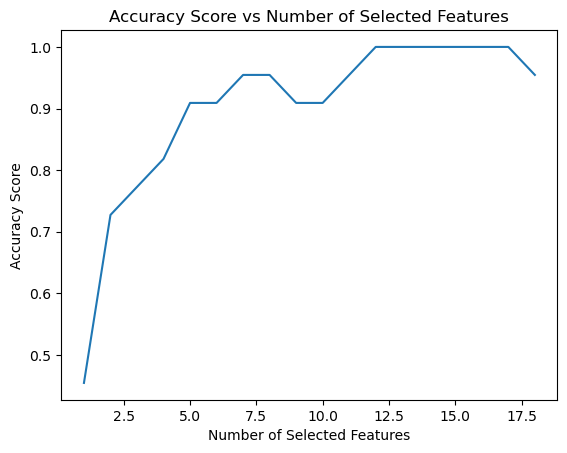

The number of features that yields the highest accuracy score is: 12


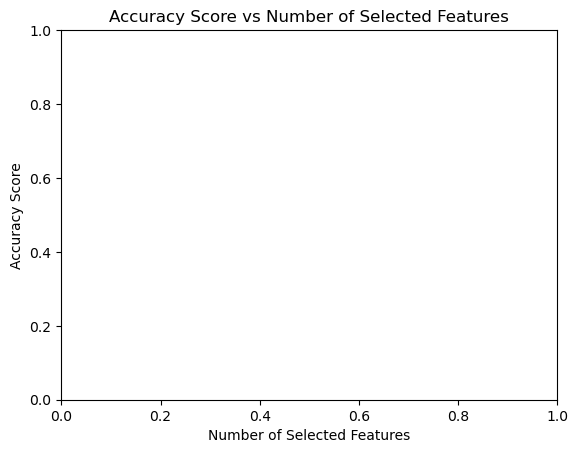

In [14]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector

accuracy_scores = []
best_num_features = 0
best_accuracy = 0

for i in range(1, features):
    model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1500, random_state=3)
    sfs = SequentialFeatureSelector(model, n_features_to_select=i)
    sfs.fit(x_train_normalized_split, y_train_split.ravel())

    X_train_selected = sfs.transform(x_train_normalized_split)
    X_val_selected = sfs.transform(x_val_normalized)

    model.fit(X_train_selected, y_train_split.ravel())
    y_pred = model.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_features = i

plt.plot(range(1, features), accuracy_scores)
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Number of Selected Features')
plt.show()

print(f"The number of features that yields the highest accuracy score is: {best_num_features}")
plt.title('Accuracy Score vs Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy Score')
plt.show()









    

In [15]:
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1500)
model.fit(x_train_normalized, y_train.ravel())
y_pred = model.predict(x_train_normalized)

print(f"The accuracy score of the training data is: {accuracy_score(y_test, y_pred)}")
print(f"The confusion matrix of the model is: \n{confusion_matrix(y_test, y_pred)}")

The accuracy score of the training data is: 0.9537037037037037
The confusion matrix of the model is: 
[[26  0  0  1]
 [ 0 26  0  1]
 [ 0  0 27  0]
 [ 1  2  0 24]]


In [17]:
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1500)

sfs = SequentialFeatureSelector(model, n_features_to_select=18)
sfs.fit(x_train_normalized, y_train.ravel())

X_train_selected = sfs.transform(x_train_normalized)
X_test_selected = sfs.transform(x_test_normalized)

model.fit(X_train_selected, y_train.ravel())  
y_pred = model.predict(X_test_selected)

print(f"Accuracy score for testing data: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix or testing data: \n{confusion_matrix(y_test, y_pred)}")

Accuracy score for testing data: 0.8796296296296297
Confusion matrix or testing data: 
[[23  0  0  4]
 [ 0 26  0  1]
 [ 0  0 27  0]
 [ 4  4  0 19]]
